# Learning Blackjack Strategy from Scratch

**Theme:** Can an RL agent teach itself how to play blackjack with zero prior knowledge?  

### Imports & Setup

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

### Blackjack Environment

In [2]:
class BlackjackEnv:
    def __init__(self):
        self.deck = []
        self.player = []
        self.dealer = []
    
    def draw_card(self):
        if len(self.deck) == 0:  # reshuffle each episode
            self.deck = [1,2,3,4,5,6,7,8,9,10,10,10,10] * 4
            random.shuffle(self.deck)
        return self.deck.pop()
    
    def hand_value(self, hand):
        total = sum(hand)
        # Count ace as 11 if possible
        if 1 in hand and total + 10 <= 21:
            return total + 10, True  # usable ace
        return total, False
    
    def reset(self):
        self.player = [self.draw_card(), self.draw_card()]
        self.dealer = [self.draw_card(), self.draw_card()]
        return self._get_obs()
    
    def _get_obs(self):
        value, usable_ace = self.hand_value(self.player)
        return (value, self.dealer[0], usable_ace)
    
    def step(self, action):
        # 0 = hit, 1 = stand
        if action == 0:  # hit
            self.player.append(self.draw_card())
            value, usable_ace = self.hand_value(self.player)
            if value > 21:  # bust
                return self._get_obs(), -1, True
            return self._get_obs(), 0, False
        else:  # stand → dealer plays
            while True:
                dealer_value, dealer_usable_ace = self.hand_value(self.dealer)
                if dealer_value < 17:
                    self.dealer.append(self.draw_card())
                else:
                    break
            
            player_value, _ = self.hand_value(self.player)
            dealer_value, _ = self.hand_value(self.dealer)
            
            if dealer_value > 21 or player_value > dealer_value:
                return self._get_obs(), +1, True
            elif player_value == dealer_value:
                return self._get_obs(), 0, True
            else:
                return self._get_obs(), -1, True

### Monte Carlo Control Setup

In [3]:
def mc_control(num_episodes=500000, epsilon=0.1, gamma=1.0):
    Q = defaultdict(lambda: np.zeros(2))  # actions: 0=hit, 1=stand
    returns_sum = defaultdict(float)
    returns_count = defaultdict(float)
    
    def policy(state):
        if random.random() < epsilon:
            return random.choice([0,1])
        return np.argmax(Q[state])
    
    env = BlackjackEnv()
    
    for i in range(num_episodes):
        # Generate one episode
        episode = []
        state = env.reset()
        done = False
        while not done:
            action = policy(state)
            next_state, reward, done = env.step(action)
            episode.append((state, action, reward))
            state = next_state
        
        # Compute returns (Monte Carlo)
        G = 0
        visited = set()
        for state, action, reward in reversed(episode):
            G = gamma * G + reward
            if (state, action) not in visited:
                visited.add((state, action))
                returns_sum[(state, action)] += G
                returns_count[(state, action)] += 1
                Q[state][action] = returns_sum[(state, action)] / returns_count[(state, action)]
                
    # Derive greedy policy
    policy = {s: np.argmax(a) for s, a in Q.items()}
    return Q, policy

### Train & Visualize Policy

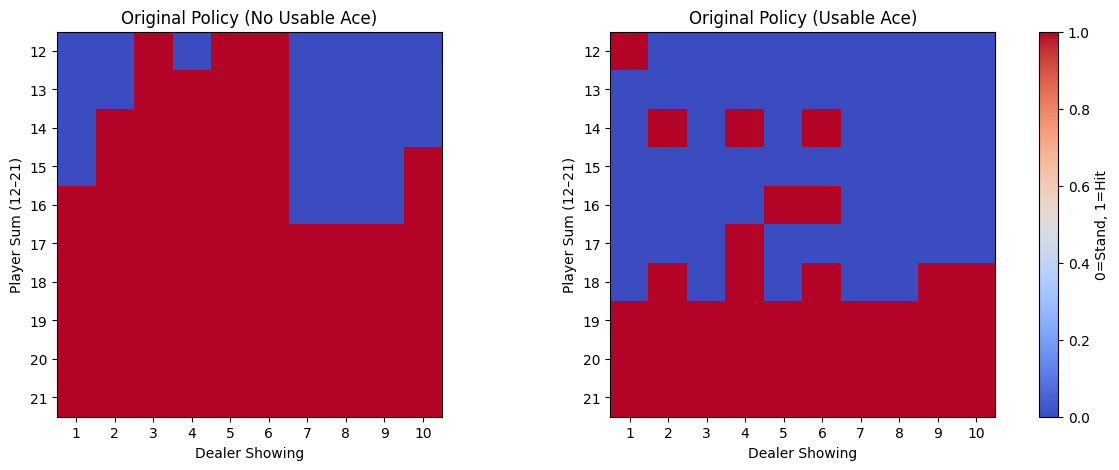

=== Policy Summary (No Usable Ace) ===
       1 2 3 4 5 6 7 8 9 10
Hard 12: S S H S H H S S S S
Hard 13: S S H H H H S S S S
Hard 14: S H H H H H S S S S
Hard 15: S H H H H H S S S H
Hard 16: H H H H H H S S S H
Hard 17: H H H H H H H H H H
Hard 18: H H H H H H H H H H
Hard 19: H H H H H H H H H H
Hard 20: H H H H H H H H H H
Hard 21: H H H H H H H H H H

=== Policy Summary (Usable Ace) ===
       1 2 3 4 5 6 7 8 9 10
Soft 12: H S S S S S S S S S
Soft 13: S S S S S S S S S S
Soft 14: S H S H S H S S S S
Soft 15: S S S S S S S S S S
Soft 16: S S S S H H S S S S
Soft 17: S S S H S S S S S S
Soft 18: S H S H S H S S H H
Soft 19: H H H H H H H H H H
Soft 20: H H H H H H H H H H
Soft 21: H H H H H H H H H H


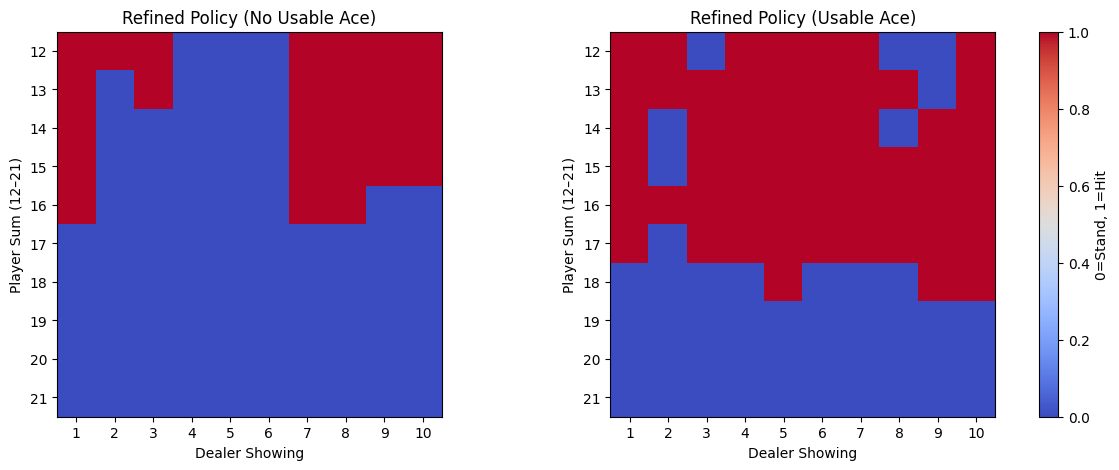

=== Refined Policy Summary (No Usable Ace) ===
       1 2 3 4 5 6 7 8 9 10
Hard 12: H H H S S S H H H H
Hard 13: H S H S S S H H H H
Hard 14: H S S S S S H H H H
Hard 15: H S S S S S H H H H
Hard 16: H S S S S S H H S S
Hard 17: S S S S S S S S S S
Hard 18: S S S S S S S S S S
Hard 19: S S S S S S S S S S
Hard 20: S S S S S S S S S S
Hard 21: S S S S S S S S S S

=== Refined Policy Summary (Usable Ace) ===
       1 2 3 4 5 6 7 8 9 10
Soft 12: H H S H H H H S S H
Soft 13: H H H H H H H H S H
Soft 14: H S H H H H H S H H
Soft 15: H S H H H H H H H H
Soft 16: H H H H H H H H H H
Soft 17: H S H H H H H H H H
Soft 18: S S S S H S S S H H
Soft 19: S S S S S S S S S S
Soft 20: S S S S S S S S S S
Soft 21: S S S S S S S S S S


In [4]:
# --- Train the agent (Original MC Control) ---
Q, policy = mc_control(num_episodes=200_000)

# --- Unified function to build policy grid ---
def extract_policy_grid(policy, usable_ace):
    """Create a 10x10 grid of actions for heatmap visualization."""
    grid = np.zeros((10, 10))  # rows=player_sum 12–21, cols=dealer_up 1–10
    for player in range(12, 22):
        for dealer in range(1, 11):
            state = (player, dealer, usable_ace)
            grid[player-12, dealer-1] = policy.get(state, 0)  # default = STAND
    return grid

# --- Build grids ---
no_ace = extract_policy_grid(policy, False)
ace = extract_policy_grid(policy, True)

# --- Heatmap visualization with labeled axes ---
def plot_policy_heatmaps(no_ace_grid, ace_grid, title_suffix=""):
    fig, axes = plt.subplots(1, 2, figsize=(14,5))
    for ax, grid, label in zip(axes, [no_ace_grid, ace_grid], ["No Usable Ace", "Usable Ace"]):
        im = ax.imshow(grid, cmap="coolwarm", origin="upper")
        ax.set_title(f"{title_suffix} Policy ({label})")
        ax.set_xlabel("Dealer Showing")
        ax.set_ylabel("Player Sum (12–21)")
        ax.set_xticks(np.arange(10))
        ax.set_xticklabels(np.arange(1, 11))
        ax.set_yticks(np.arange(10))
        ax.set_yticklabels(np.arange(12, 22))
    fig.colorbar(im, ax=axes, orientation='vertical', fraction=0.025, pad=0.04, label="0=Stand, 1=Hit")
    plt.show()

plot_policy_heatmaps(no_ace, ace, title_suffix="Original")

# --- Text summary of policy with header ---
def summarize_policy(policy, usable_ace):
    actions_map = {0: "S", 1: "H"}
    header = "       " + " ".join([str(d) for d in range(1, 11)])  # Dealer cards 1–10
    summary = [header]
    for player in range(12, 22):
        line = []
        for dealer in range(1, 11):
            state = (player, dealer, usable_ace)
            action = policy.get(state, 0)
            line.append(actions_map[action])
        summary.append(f"{'Soft' if usable_ace else 'Hard'} {player}: " + " ".join(line))
    return "\n".join(summary)

print("=== Policy Summary (No Usable Ace) ===")
print(summarize_policy(policy, False))
print("\n=== Policy Summary (Usable Ace) ===")
print(summarize_policy(policy, True))

# === Refined Training: Gymnasium MC Control with Epsilon Decay ===
import gymnasium as gym

env = gym.make("Blackjack-v1", natural=True, sab=False)

def mc_control_epsilon_decay(env, num_episodes=500_000, gamma=1.0, epsilon_start=0.1, epsilon_end=0.01):
    """Monte Carlo Control with linear epsilon decay."""
    Q, returns_sum, returns_count = {}, {}, {}
    nA = env.action_space.n

    for episode in range(1, num_episodes+1):
        epsilon = max(epsilon_end, epsilon_start * (1 - episode/num_episodes))
        episode_memory = []
        state, _ = env.reset()
        done = False

        while not done:
            if state not in Q:
                Q[state] = np.zeros(nA)
            action = np.random.choice(nA) if np.random.rand() < epsilon else np.argmax(Q[state])
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            episode_memory.append((state, action, reward))
            state = next_state

        # Compute returns
        G = 0
        visited = set()
        for state, action, reward in reversed(episode_memory):
            G = gamma * G + reward
            if (state, action) not in visited:
                visited.add((state, action))
                returns_sum[(state, action)] = returns_sum.get((state, action), 0) + G
                returns_count[(state, action)] = returns_count.get((state, action), 0) + 1
                Q[state][action] = returns_sum[(state, action)] / returns_count[(state, action)]

    policy = {state: np.argmax(actions) for state, actions in Q.items()}
    return Q, policy

# --- Run refined training ---
Q_refined, policy_refined = mc_control_epsilon_decay(env)

# --- Build grids and plot refined heatmaps ---
no_ace_refined = extract_policy_grid(policy_refined, False)
ace_refined = extract_policy_grid(policy_refined, True)
plot_policy_heatmaps(no_ace_refined, ace_refined, title_suffix="Refined")

# --- Text summary of refined policy ---
print("=== Refined Policy Summary (No Usable Ace) ===")
print(summarize_policy(policy_refined, False))
print("\n=== Refined Policy Summary (Usable Ace) ===")
print(summarize_policy(policy_refined, True))